In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

subset100 = pd.read_csv("../raw_data/track_meta_100subset_new.csv")

In [3]:
subset100_new = subset100[['Playlistid', 'Trackid', 'Artist_Name', 'Track_uri',
                           'Track_Name', 'Album_Name', 'Track_Duration',
                           'acousticness', 'artist_genres', 'artist_popularity',
                           'danceability', 'energy', 'explicit', 'instrumentalness', 'key',
                           'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
                           'time_signature', 'valence']] #keep columns of interest

In [4]:
subset100_new.describe()

,Playlistid,Trackid,Track_Duration,acousticness,artist_popularity,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000,3079.000000
mean,141430.921728,24.724261,231110.976616,0.179124,74.487821,0.642737,0.667381,0.016271,5.137707,0.187531,-6.535065,0.644690,0.112890,122.456843,3.967847,0.520836
std,85921.299098,24.255188,52566.233704,0.221431,12.999891,0.144650,0.178598,0.093602,3.664256,0.150499,2.766270,0.478685,0.112955,28.402454,0.280291,0.227985
min,430.000000,0.000000,36400.000000,0.000006,0.000000,0.093000,0.006880,0.000000,0.000000,0.021000,-37.315000,0.000000,0.022500,60.048000,1.000000,0.028600
25%,61388.000000,7.000000,201250.000000,0.019750,67.000000,0.547000,0.545000,0.000000,1.000000,0.092600,-7.816000,0.000000,0.039400,100.000000,4.000000,0.348000
50%,155598.000000,17.000000,224386.000000,0.079600,75.000000,0.652000,0.690000,0.000000,5.000000,0.128000,-6.056000,1.000000,0.061600,120.462000,4.000000,0.514000
75%,221044.000000,34.000000,254040.000000,0.255000,84.000000,0.743000,0.808000,0.000053,8.000000,0.241000,-4.619500,1.000000,0.138000,140.023000,4.000000,0.707000
max,271274.000000,134.000000,669133.000000,0.977000,100.000000,0.978000,0.991000,0.944000,11.000000,0.966000,-0.698000,1.000000,0.808000,209.893000,5.000000,0.982000


## Train-Test Split

In [5]:
# Train-val-test split (20%)
train, test = train_test_split(subset100_new, test_size=0.2, random_state=48, stratify = subset100['Playlistid'])
train, val = train_test_split(train, test_size=0.2, random_state=48, stratify = train['Playlistid'])

In [6]:
train['index'] = np.arange(1, len(train)+1) #append index column for merging scaled data

## Scale Features for Clustering

In [8]:
scaleCols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
             'key', 'liveness', 'loudness', 'speechiness', 'tempo','valence', 'time_signature', 'artist_popularity'] #mode excluded from analysis
scaler = StandardScaler()
scaler.fit(train.loc[:, scaleCols])
train_scaled = train.copy() #copy original master data frame
train_scaled[scaleCols] = scaler.transform(train_scaled[scaleCols]) #scale transform cluster columns
train_scaled['index'] = np.arange(1, len(train_scaled)+1) #reappend index column
train_scaled = train_scaled.rename(columns = {'acousticness': 'acousticness_scaled',
                                              'danceability': 'danceability_scaled',
                                              'energy': 'energy_scaled',
                                              'instrumentalness': 'instrumentalness_scaled',
                                              'key': 'key_scaled',
                                              'liveness': 'liveness_scaled',
                                              'loudness': 'loudness_scaled',
                                              'speechiness': 'speechiness_scaled',
                                              'tempo': 'tempo_scaled',
                                              'valence': 'valence_scaled',
                                              'time_signature': 'time_signature_scaled',
                                              'artist_popularity': 'artist_popularity_scaled'})
joinCols = ['index', 'Playlistid', 'Trackid', 'Track_uri', 'Artist_Name',
            'Track_Name', 'Album_Name', 'Track_Duration', 
            'artist_genres', 'explicit', 'mode']
train_new = train.merge(train_scaled, on = joinCols, how = 'outer') #merge scaled data with original data

## Optimal K

In [9]:
clusterCols = ['acousticness_scaled','danceability_scaled', 
               'energy_scaled', 'instrumentalness_scaled',
               'key_scaled', 'liveness_scaled', 'loudness_scaled',
               'speechiness_scaled', 'tempo_scaled', 'time_signature_scaled',
               'valence_scaled'] #variables to cluster
train_new[clusterCols].corr() #check variable correlations

,acousticness_scaled,danceability_scaled,energy_scaled,instrumentalness_scaled,key_scaled,liveness_scaled,loudness_scaled,speechiness_scaled,tempo_scaled,time_signature_scaled,valence_scaled
acousticness_scaled,1.000000,-0.163588,-0.523951,0.082649,0.025935,-0.049194,-0.405761,0.023215,-0.101019,-0.153946,-0.142976
danceability_scaled,-0.163588,1.000000,-0.057246,-0.116860,-0.038128,-0.091771,0.037367,0.135107,-0.167829,0.092965,0.309010
energy_scaled,-0.523951,-0.057246,1.000000,-0.090308,0.030592,0.184011,0.713036,-0.086500,0.115240,0.136433,0.373842
instrumentalness_scaled,0.082649,-0.116860,-0.090308,1.000000,0.000249,-0.021109,-0.216606,-0.086806,-0.010039,-0.065067,-0.106932
key_scaled,0.025935,-0.038128,0.030592,0.000249,1.000000,0.006367,0.010182,0.043538,0.004060,-0.029625,0.003128
liveness_scaled,-0.049194,-0.091771,0.184011,-0.021109,0.006367,1.000000,0.108052,0.093809,0.040932,0.018652,0.029931
loudness_scaled,-0.405761,0.037367,0.713036,-0.216606,0.010182,0.108052,1.000000,-0.048305,0.114075,0.109111,0.212452
speechiness_scaled,0.023215,0.135107,-0.086500,-0.086806,0.043538,0.093809,-0.048305,1.000000,0.111326,-0.024010,-0.027557
tempo_scaled,-0.101019,-0.167829,0.115240,-0.010039,0.004060,0.040932,0.114075,0.111326,1.000000,0.034723,0.001161
time_signature_scaled,-0.153946,0.092965,0.136433,-0.065067,-0.029625,0.018652,0.109111,-0.024010,0.034723,1.000000,0.074624


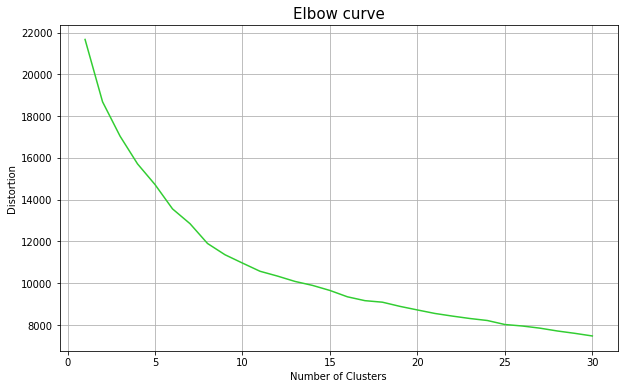

In [28]:
clusterCols = ['acousticness_scaled','danceability_scaled', 
               'energy_scaled', 'instrumentalness_scaled',
               'key_scaled', 'liveness_scaled', 'loudness_scaled',
               'speechiness_scaled', 'tempo_scaled', 'time_signature_scaled',
               'valence_scaled'] #variables to cluster

distortion = list()
for k in range(1, 31): #started with range [1, 51] and narrowed down to this range 
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(train_new.loc[:, clusterCols])
    distortion.append(kmeans.inertia_) #append distortion value to list

#plot elbow curves 
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), distortion, c = 'limegreen', label = 'distortion')
plt.xlabel('Number of Clusters', fontsize = 10)
plt.ylabel('Distortion', fontsize = 10)
plt.grid(True)
plt.title('Elbow curve', fontsize = 15)
plt.show()

In [29]:
fig.savefig('optimalk_demo.png')

In [30]:
#initiate clusters
def makeCluster(df, n, rs, cols):
    '''
    Parameters:
    1) df: master data frame
    2) n: number of clusters
    3) rs: random state
    4) cols: list of clustering variables
    '''
    #copy dataframe
    dfCluster = df.copy()

    #fit clusters
    kmeans = KMeans(n_clusters = n, random_state = rs)
    kmeans.fit(dfCluster.loc[:, cols])

    #get location of cluster centroids and label
    center = kmeans.cluster_centers_
    label = kmeans.labels_
    dfCluster['cluster_label'] = label
    dfCluster['cluster_label'] = dfCluster['cluster_label'] + 1 #increment by 1 so 0 implies non-existence in prediction
    
    #append centroids to data frame
    centroids = defaultdict(list)
    for col in cols:
        centroids['columns'].append(col)
    for a in range(len(center)):
        for b in range(len(center[0])):
            centroids['c'+ str(a)].append(center[a][b])
            dfCluster['c'+ str(a) + cols[b]] = center[a][b]

    return dfCluster, pd.DataFrame.from_dict(centroids)

In [31]:
clusterCols = ['acousticness_scaled','danceability_scaled', 
               'energy_scaled', 'instrumentalness_scaled',
               'key_scaled', 'liveness_scaled', 'loudness_scaled',
               'speechiness_scaled', 'tempo_scaled', 'time_signature_scaled',
               'valence_scaled'] #variables to cluster

In [32]:
train_cluster, train_centroids = makeCluster(train_new, 8, 48, clusterCols)

In [33]:
#rank centroids
def rankC(dfCentroid, n):
    rankC = defaultdict(list)
    for i in range(n):
        rankC['cluster'].append(i)
        for j in range(n):
            rankC[str(j)].append(euclidean(dfCentroid['c'+str(i)], dfCentroid['c'+str(j)]))    
    rankC = pd.DataFrame(rankC)
    orderRankC = defaultdict(list)
    for i in range(n):
        orderRankC[str(i)] = rankC[str(i)].sort_values(ascending = True).index.values
    return orderRankC

In [34]:
orderRankc = rankC(train_centroids, 5)

In [35]:
prediction_cluster = train_cluster[['Playlistid', 'Trackid', 'Track_uri', 'Artist_Name', 'Track_Name',
                                   'artist_genres','artist_popularity', 'cluster_label']]

In [36]:
mode_artist = prediction_cluster.groupby(['cluster_label', 'Artist_Name'])['Playlistid'].count().reset_index()
mode_artist = mode_artist.rename(columns = {'Playlistid': 'mode_artist'})
prediction_cluster = prediction_cluster.merge(mode_artist, on = ['cluster_label', 'Artist_Name'])

In [37]:
mode_track = prediction_cluster.groupby(['cluster_label', 'Track_Name'])['Playlistid'].count().reset_index()
mode_track = mode_track.rename(columns = {'Playlistid': 'mode_track'})
prediction_cluster = prediction_cluster.merge(mode_track, on = ['cluster_label', 'Track_Name'])

## Prediction

In [20]:
#model before tuning
import predict_cluster

#model updated
import predict_cluster_updated

In [72]:
#demo, for playlist number 
example = prediction_cluster[prediction_cluster.Playlistid == 20043]
#training set
example

,Playlistid,Trackid,Track_uri,Artist_Name,Track_Name,artist_genres,artist_popularity,cluster_label,mode_artist,mode_track
23,20043,20,spotify:track:1vvnYpYEMVB4aq9I6tHIEB,J. Cole,4 Your Eyez Only,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,1
134,20043,0,spotify:track:6F609ICg9Spjrw1epsAnpa,Drake,Controlla,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,7,51,2
138,20043,3,spotify:track:6bqtKURdSWkInAJHDkuaL0,Drake,I'm The Plug,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,7,51,2
144,20043,2,spotify:track:7jslhIiELQkgW9IHeYNOWE,Drake,Big Rings,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,7,51,3
159,20043,8,spotify:track:124NFj84ppZ5pAxTuVQYCQ,Drake,Take Care,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,7,51,3
238,20043,1,spotify:track:11KJSRSgaDxqydKYiD2Jew,Drake,Too Good,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,4,34,3
245,20043,7,spotify:track:6LxSe8YmdPxy095Ux6znaQ,Drake,Headlines,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,4,34,5
282,20043,59,spotify:track:7GX5flRQZVHRAGd6B4TmDO,Lil Uzi Vert,XO TOUR Llif3,"['pop', 'rap', 'trap music']",86.0,7,5,5
321,20043,31,spotify:track:7kqcudBGM74MXVoYMaoWkC,Chris Brown,Loyal,"['dance pop', 'pop', 'pop rap', 'r&b', 'rap']",86.0,2,11,1
323,20043,34,spotify:track:3wrP2GVxWH8VpHPOsKhYgz,Chris Brown,Zero,"['dance pop', 'pop', 'pop rap', 'r&b', 'rap']",86.0,2,11,1


In [73]:
#predict for demo
pred_example = predict_cluster.cPredict(prediction_cluster, 20043, orderRankc, val)
#visualize tracks predicted for the example data set
dfpred_example = prediction_cluster[prediction_cluster.Track_uri.isin(pred_example)]
dfpred_example

,Playlistid,Trackid,Track_uri,Artist_Name,Track_Name,artist_genres,artist_popularity,cluster_label,mode_artist,mode_track
18,46047,0,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4
19,153929,65,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4
20,22204,14,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4
21,190503,7,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4
22,219212,10,spotify:track:3FWR4iiUUPHIK7OpiEgh8J,J. Cole,Lost Ones,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,1
24,219212,3,spotify:track:16qYlQ6koFxYVbiJbGHblz,J. Cole,G.O.M.D.,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,2
25,193450,19,spotify:track:16qYlQ6koFxYVbiJbGHblz,J. Cole,G.O.M.D.,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,2
26,208692,34,spotify:track:6I6NX6tjGsxFAsIfGzY9lJ,J. Cole,Deja Vu,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,1
27,190503,13,spotify:track:7lL3MvFWFFSD25pBz72Agj,J. Cole,A Tale of 2 Citiez,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,1
28,219212,2,spotify:track:6Ius4TC0L3cN74HT7ENE6e,J. Cole,Wet Dreamz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,1


In [74]:
#true validation set for demo
true_example = val[val.Playlistid == 20043]
true_example

,Playlistid,Trackid,Artist_Name,Track_uri,Track_Name,Album_Name,Track_Duration,acousticness,artist_genres,artist_popularity,...,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
428,20043,61,Bryson Tiller,spotify:track:3Jrs7cC2OJNlNSy9VnDOMZ,Somethin Tells Me,True to Self,194266,0.035600,"['hip hop', 'indie r&b', 'pop', 'pop rap', 'r&...",76.0,...,True,0.000000,5.0,0.1070,-7.197,0.0,0.2260,90.002,4.0,0.4340
429,20043,62,A Boogie Wit da Hoodie,spotify:track:1f5cbQtDrykjarZVrShaDI,Drowning (feat. Kodak Black),The Bigger Artist,209269,0.501000,"['hip hop', 'pop', 'rap', 'southern hip hop', ...",78.0,...,True,0.000000,5.0,0.1170,-5.274,0.0,0.0568,129.014,4.0,0.8140
377,20043,10,Drake,spotify:track:4Kz4RdRCceaA9VgTqBhBfa,The Motto,Take Care,181573,0.000107,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,...,True,0.000061,1.0,0.1110,-8.558,1.0,0.3560,201.800,4.0,0.3900
393,20043,26,Nicki Minaj,spotify:track:73DydXpS6xXmsFNvYrSpIQ,Favorite,The Pinkprint,242946,0.613000,"['dance pop', 'hip pop', 'pop', 'pop rap', 'rap']",90.0,...,True,0.000057,4.0,0.0911,-7.172,0.0,0.0408,103.038,4.0,0.0635
395,20043,28,Nicki Minaj,spotify:track:7gKIt3rDGIMJDFVSPBnGmj,Super Bass,Pink Friday,200013,0.290000,"['dance pop', 'hip pop', 'pop', 'pop rap', 'rap']",90.0,...,True,0.000003,11.0,0.5030,-4.302,1.0,0.1960,127.033,4.0,0.6390
425,20043,58,DeJ Loaf,spotify:track:2CY92qejUrhyPUASawNVRr,Try Me,Try Me,217573,0.007100,"['deep pop r&b', 'detroit hip hop', 'pop', 'po...",65.0,...,True,0.000008,0.0,0.2410,-8.029,0.0,0.0872,170.044,4.0,0.2470
378,20043,11,Big Sean,spotify:track:0SGkqnVQo9KPytSri1H6cF,Bounce Back,I Decided.,222360,0.105000,"['detroit hip hop', 'hip hop', 'pop', 'pop rap...",83.0,...,True,0.000000,2.0,0.1250,-5.698,1.0,0.1750,81.477,4.0,0.2600
405,20043,38,Kid Ink,spotify:track:32tBNiuuQtkUG5eBWpC0oQ,Be Real,Full Speed,206760,0.122000,"['dance pop', 'hip hop', 'pop', 'pop rap', 'r&...",73.0,...,True,0.000315,9.0,0.1410,-5.462,0.0,0.0876,99.934,4.0,0.3860
388,20043,21,J. Cole,spotify:track:6Ius4TC0L3cN74HT7ENE6e,Wet Dreamz,2014 Forest Hills Drive,239320,0.075200,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,...,True,0.000000,6.0,0.1280,-8.205,0.0,0.3640,175.483,4.0,0.5840
372,20043,5,Drake,spotify:track:2durxb17bXcmQJHSt8JAdO,No Tellin',If You're Reading This It's Too Late,310933,0.535000,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,...,True,0.000000,7.0,0.1360,-10.408,0.0,0.2750,95.030,4.0,0.5580


In [75]:
#predict for demo using updated model
pred_example_updated = predict_cluster_updated.cPredict(prediction_cluster, 20043, orderRankc, val)
dfpred_example_updated = prediction_cluster[prediction_cluster.Track_uri.isin(pred_example_updated)]
dfpred_example_updated

,Playlistid,Trackid,Track_uri,Artist_Name,Track_Name,artist_genres,artist_popularity,cluster_label,mode_artist,mode_track
4,61388,36,spotify:track:1D9XLqQp2YYiOxrr5KLb8K,Drake,Under Ground Kings,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,1
5,153929,33,spotify:track:31Q9ZTF9x81BDonlObCbvP,Drake,Forever,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,1
6,153929,43,spotify:track:75L0qdzRnhwV62UXoNq3pE,Drake,Up All Night,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,2
7,230183,8,spotify:track:75L0qdzRnhwV62UXoNq3pE,Drake,Up All Night,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,2
8,155081,6,spotify:track:6cT5orvyKqwghJp6KB9vG0,Drake,Furthest Thing,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,1
9,190503,9,spotify:track:0V4l4GQhgnWQGtCWpvA7va,Drake,Crew Love,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,1
10,153929,63,spotify:track:3fyMH1t6UPeR5croea9PrR,Drake,Best I Ever Had,"['canadian hip hop', 'canadian pop', 'hip hop'...",100.0,3,7,1
18,46047,0,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4
19,153929,65,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4
20,22204,14,spotify:track:62vpWI1CHwFy7tMIcSStl8,J. Cole,No Role Modelz,"['conscious hip hop', 'hip hop', 'pop', 'pop r...",84.0,7,11,4


## Performance

In [19]:
def r_precision(prediction, val_set):
# prediction should be a list of predictions
# val_set should be pandas Series of ground truths
    score = np.sum(val_set.isin(prediction))/val_set.shape[0]
    return score

### NDCG Code Source: https://gist.github.com/bwhite/3726239
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [21]:
#original model
rps = []
ndcgs = []
for pid in val.Playlistid.unique():
    ps = predict_cluster.cPredict(prediction_cluster, pid, orderRankc, val) # predictions
    vs = val[val.Playlistid == pid].Track_uri # ground truth
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))

In [22]:
#original model
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)
print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)
print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.036147241647241646
Avg. NDCG:  0.037807636883426095
Total Sum:  0.03697743926533387


In [25]:
#updated model
rps = []
ndcgs = []
for pid in test.Playlistid.unique():
    ps = predict_cluster_updated.cPredict(prediction_cluster, pid, orderRankc, test) # predictions
    vs = test[test.Playlistid == pid].Track_uri # ground truth
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))

In [26]:
#updated model
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)
print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)
print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.07752596789748493
Avg. NDCG:  0.1140693722597518
Total Sum:  0.09579767007861836
